In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import files
import pandas as pd

# Upload file dari lokal
uploaded = files.upload()

# Ambil nama file yang diupload
for filename in uploaded.keys():
    print(f"File yang diupload: {filename}")
    # Baca file Excel
    df = pd.read_excel(filename)
    print(df.head())

Saving hasil_preprocessing2.xlsx to hasil_preprocessing2.xlsx
File yang diupload: hasil_preprocessing2.xlsx
  PENERBIT                                              JUDUL  \
0    Detik  dirjen pajak ungkap kabar terbaru soal perbaik...   
1    Detik  djp klaim aplikasi coretax mulai stabil digunakan   
2     DDTC  latensi turun, djp klaim coretax system sudah ...   
3    Detik  awas penipuan catut nama coretax! begini modus...   
4    Tempo  hari ini direktorat jenderal pajak rapat tertu...   

                                             content         date_final  \
0  direktur jenderal (dirjen) pukak suryo utomo m...  Tidak ada tanggal   
1  direktorat jenderal pajak (djp) kementerian ke...         25-03-2025   
2  ilustrasi.jakarta, ddtcnews - ditjen pajak (dj...         30-04-2025   
3  ditjen pajak (djp) kementerian keuigan (kemenk...  Tidak ada tanggal   
4  gulir ke bawah untuk bemaca berita baca berita...         01-01-2025   

       SUMBER    Label                            

In [3]:
# Load dataset
df = pd.read_excel("hasil_preprocessing2.xlsx")

In [4]:
import ast

# Ubah string seperti list menjadi list asli (jika memang masih string)
df['rareword_removed'] = df['rareword_removed'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Gabungkan token jadi kalimat
df['konten_final'] = df['rareword_removed'].apply(lambda tokens: ' '.join(tokens))

In [5]:
# #Hanya akan menampilkan kolom berikut
df = df.loc[:,["SUMBER","PENERBIT","JUDUL", "date_final", "konten_final", "Label"]]
df

,SUMBER,PENERBIT,JUDUL,date_final,konten_final,Label
0,economic,Detik,dirjen pajak ungkap kabar terbaru soal perbaik...,Tidak ada tanggal,direktur pukak suryo utomo mengungkapkan kabar...,positif
1,economic,Detik,djp klaim aplikasi coretax mulai stabil digunakan,25-03-2025,rata berada bawah performa tercatat april kemu...,netral
2,local news,DDTC,"latensi turun, djp klaim coretax system sudah ...",30-04-2025,pajak menilai performa coretax administration ...,negatif
3,economic,Detik,awas penipuan catut nama coretax! begini modus...,Tidak ada tanggal,akhir penipuan mengatasnamakan menerapkan sist...,negatif
4,local news,Tempo,hari ini direktorat jenderal pajak rapat tertu...,01-01-2025,direktur dirjen pajak kementerian suryo pajak ...,negatif
...,...,...,...,...,...,...
165,local news,NTVNews,"banyak dikeluhkan warga, apa tujuan sebenarnya...",08-01-2025,serang pusat pajak ekonomi bisnis universitas ...,negatif
166,local news,katadata,"coretax masih bermasalah, ditjen pajak akan gu...",01-01-2025,kementerian mengumumkan pendapatan hingga akhi...,negatif
167,opinion,CNN,jeblok setoran pajak gara-gara coretax dan keb...,28-02-2025,directorate general kementerian terus melakuka...,negatif
168,local news,Hukum Online,"kantor hukum keluhkan kendala coretax, ganggu ...",Tidak ada tanggal,semuanya memiliki fungsi masing masing melapor...,negatif


In [6]:
# Encode label
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['Label'])

In [7]:
# Hitung jumlah data per label setelah augmentasi swap
print(df['label_encoded'].value_counts())

label_encoded
1    67
0    52
2    51
Name: count, dtype: int64


In [8]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 22.2 MB/s eta 0:00:00


In [9]:
import nlpaug.augmenter.word as naw
import pandas as pd
from collections import Counter

# Augmenter
aug = naw.RandomWordAug(action="swap")

# Target data per label agar total ~300
target_per_label = 100

# Hitung jumlah data per label dari data asli
label_counts = Counter(df['label_encoded'])

# List untuk menyimpan hasil augmentasi
augmented_texts = []
augmented_labels = []

# Augmentasi hanya jika jumlah < target
for label_value, count in label_counts.items():
    n_to_augment = target_per_label - count
    if n_to_augment > 0:
        print(f"🔄 Mengaugmentasi label {label_value} sebanyak {n_to_augment} sampel...")
        df_subset = df[df['label_encoded'] == label_value]
        df_sample = df_subset.sample(n=n_to_augment, replace=True, random_state=42)

        for text in df_sample['konten_final']:
            try:
                aug_text = aug.augment(text)
                augmented_texts.append(aug_text)
                augmented_labels.append(label_value)
            except Exception as e:
                print(f"⚠️ Gagal augmentasi: {e}")
                continue

🔄 Mengaugmentasi label 2 sebanyak 49 sampel...
🔄 Mengaugmentasi label 1 sebanyak 33 sampel...
🔄 Mengaugmentasi label 0 sebanyak 48 sampel...


In [10]:
# Gabungkan data augmentasi jadi DataFrame baru
df_aug = pd.DataFrame({
    'konten_final': augmented_texts,
    'label_encoded': augmented_labels
})

# Gabungkan dengan data asli
df_full = pd.concat([df[['konten_final', 'label_encoded']], df_aug], ignore_index=True)

# Cek distribusi hasil akhir
print("\n📊 Distribusi label setelah augmentasi:")
print(df_full['label_encoded'].value_counts())
print(f"\n📈 Total data setelah augmentasi swap: {len(df_full)}")


📊 Distribusi label setelah augmentasi:
label_encoded
2    100
1    100
0    100
Name: count, dtype: int64

📈 Total data setelah augmentasi swap: 300


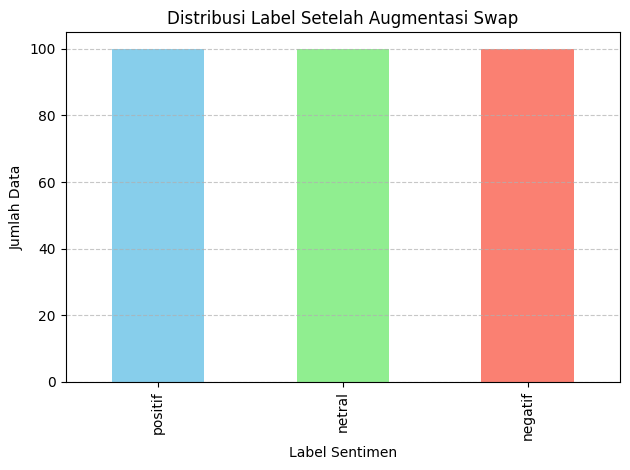

In [11]:
import matplotlib.pyplot as plt

df_full['Label'] = le.inverse_transform(df_full['label_encoded'])

# Plot distribusi label setelah augmentasi swap
df_full['Label'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])

plt.title("Distribusi Label Setelah Augmentasi Swap")
plt.xlabel("Label Sentimen")
plt.ylabel("Jumlah Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
df_full

,konten_final,label_encoded,Label
0,direktur pukak suryo utomo mengungkapkan kabar...,2,positif
1,rata berada bawah performa tercatat april kemu...,1,netral
2,pajak menilai performa coretax administration ...,0,negatif
3,akhir penipuan mengatasnamakan menerapkan sist...,0,negatif
4,direktur dirjen pajak kementerian suryo pajak ...,0,negatif
...,...,...,...
295,[pendapatan sisi mengalami pajak penurunan feb...,0,negatif
296,[Undangan hukum terkini solusi hukum advokat b...,0,negatif
297,[mughu pengalaman menemukan celah keamanan sis...,0,negatif
298,[pajak akhirnya suara suara suara menuai kriti...,0,negatif


In [13]:
df_full['konten_final'] = df_full['konten_final'].apply(
    lambda x: ' '.join(x) if isinstance(x, list) else x
)

# Model Bert

In [28]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

In [15]:
# 1. Persiapan dataset
class IndoBERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [16]:
# 2. Tokenizer & Model
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# 3. Split data
df_full['label_encoded'] = df_full['label_encoded'].astype(int)

# Siapkan data
texts = df_full['konten_final'].astype(str).tolist()
labels = df_full['label_encoded'].tolist()

# Split train-val-test
X_temp, X_test, y_temp, y_test = train_test_split(
    texts, labels, test_size=0.15, stratify=labels, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)  # agar val = 15% dari total

# Dataset dan DataLoader
train_dataset = IndoBERTDataset(X_train, y_train, tokenizer)
val_dataset = IndoBERTDataset(X_val, y_val, tokenizer)
test_dataset = IndoBERTDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [30]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer dan loss
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# (Opsional) Tambahkan dropout config untuk BERT
model.config.hidden_dropout_prob = 0.3
model.config.attention_probs_dropout_prob = 0.3

# Tracking loss dan early stopping
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 2
patience_counter = 0
epochs = 5


In [31]:

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        # ✅ Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 🔍 Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

    # ✅ Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"⏹ Early stopping triggered at epoch {epoch+1}")
            break

Epoch 1: 100%|██████████| 27/27 [00:05<00:00,  5.03it/s]


Epoch 1 - Train Loss: 0.0008 | Validation Loss: 0.0003


Epoch 2: 100%|██████████| 27/27 [00:05<00:00,  5.39it/s]


Epoch 2 - Train Loss: 0.0002 | Validation Loss: 0.0002


Epoch 3: 100%|██████████| 27/27 [00:04<00:00,  5.41it/s]


Epoch 3 - Train Loss: 0.0001 | Validation Loss: 0.0001


Epoch 4: 100%|██████████| 27/27 [00:05<00:00,  5.37it/s]


Epoch 4 - Train Loss: 0.0001 | Validation Loss: 0.0001


Epoch 5: 100%|██████████| 27/27 [00:05<00:00,  5.35it/s]


Epoch 5 - Train Loss: 0.0001 | Validation Loss: 0.0001


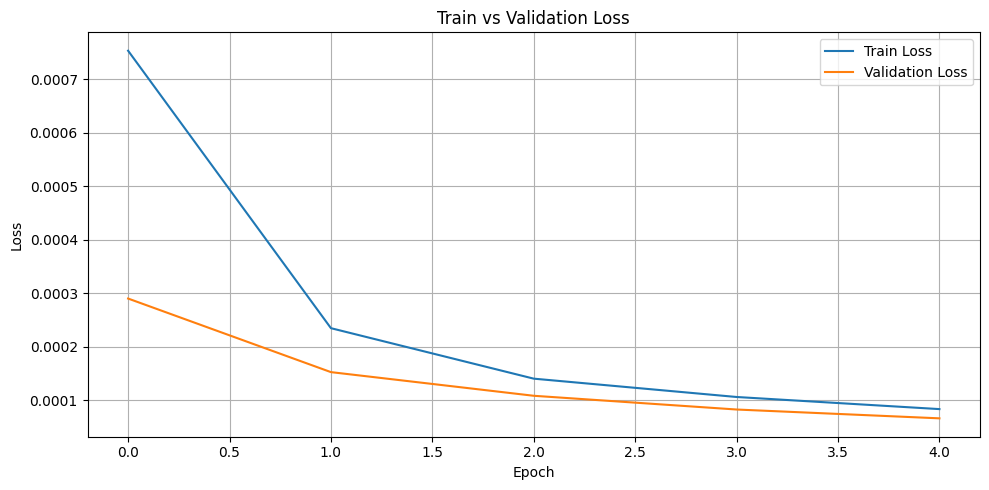

In [32]:
# 📈 Visualisasi loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
# 5. Evaluasi
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=["Negatif", "Netral", "Positif"]))


              precision    recall  f1-score   support

     Negatif       0.94      1.00      0.97        15
      Netral       1.00      0.93      0.97        15
     Positif       0.93      0.93      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



## Melihat Prediksi untuk Semua Data

In [39]:
# Siapkan teks dan label dari seluruh dataset
all_texts = df_full['konten_final'].astype(str).tolist()
all_labels = df_full['label_encoded'].tolist()

# Buat Dataset dan DataLoader
full_dataset = IndoBERTDataset(all_texts, all_labels, tokenizer)
full_loader = DataLoader(full_dataset, batch_size=8)


In [43]:
# Prediksi seluruh dataset
model.eval()
all_true = []
all_pred = []

with torch.no_grad():
    for batch in full_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        all_true.extend(labels.cpu().numpy())
        all_pred.extend(predictions.cpu().numpy())

In [42]:
import numpy as np

all_true = np.array(all_true)
all_pred = np.array(all_pred)

jumlah_benar = np.sum(all_true == all_pred)
jumlah_salah = np.sum(all_true != all_pred)

print(f"✅ Jumlah data yang berhasil diprediksi dengan benar: {jumlah_benar}")
print(f"❌ Jumlah data yang salah diprediksi: {jumlah_salah}")
print(f"📦 Total data yang diprediksi: {len(all_true)}")

✅ Jumlah data yang berhasil diprediksi dengan benar: 298
❌ Jumlah data yang salah diprediksi: 2
📦 Total data yang diprediksi: 300


In [103]:
kalimat_uji = [
    "Pemerintah berjanji akan menurunkan pajak, meski belum jelas kapan dan bagaimana caranya.",  # ambigu
    "Masyarakat akhirnya bisa senang, karena sistem perpajakan baru membuat mereka harus membayar lebih dari sebelumnya.",  # sarkastik
    "Penerapan sistem perpajakan digital melalui Coretax disambut dengan beragam respons dari masyarakat, di mana sebagian pihak menganggapnya sebagai langkah modernisasi yang penting, sementara lainnya masih mencoba menyesuaikan diri dengan perubahan teknis dan prosedural yang cukup signifikan, tanpa memberikan penilaian langsung terhadap dampaknya sejauh ini.",
    "Coretax menjadi solusi semua masalah, kecuali masalah sebenarnya yang tetap tidak berubah.",  # sarkastik
    "Meskipun terdengar bagus, kebijakan ini justru mempersulit UMKM dalam pelaporannya.", # ambigu + implikasi negatif
    "Coretax memberikan pengalaman pengguna yang luar biasa!",
    "Coretax kemampuannya yang luar biasa dalam menyederhanakan proses administrasi pajak secara menyeluruh.",
    "Peluncuran fitur terbaru Coretax disambut oleh wajib pajak dari berbagai kalangan.",
    "Coretax diakui sebagai salah satu inovasi teknologi dalam bidang pelayanan publik.",
    "Coretax luar biasa!",
    "Coretax terbaik!"

]

In [104]:
# Tokenisasi dan prediksi kalimat uji
model.eval()
tokenized = tokenizer(kalimat_uji, truncation=True, padding='max_length', max_length=128, return_tensors='pt').to(device)

with torch.no_grad():
    outputs = model(**tokenized)
    predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# Mapping label numerik ke teks
label_map = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}

# Tampilkan hasil
for kalimat, pred in zip(kalimat_uji, predictions):
    print(f"\n📝 Kalimat: {kalimat}\n🔍 Prediksi Sentimen: {label_map[pred]}")


📝 Kalimat: Pemerintah berjanji akan menurunkan pajak, meski belum jelas kapan dan bagaimana caranya.
🔍 Prediksi Sentimen: Negatif

📝 Kalimat: Masyarakat akhirnya bisa senang, karena sistem perpajakan baru membuat mereka harus membayar lebih dari sebelumnya.
🔍 Prediksi Sentimen: Negatif

📝 Kalimat: Penerapan sistem perpajakan digital melalui Coretax disambut dengan beragam respons dari masyarakat, di mana sebagian pihak menganggapnya sebagai langkah modernisasi yang penting, sementara lainnya masih mencoba menyesuaikan diri dengan perubahan teknis dan prosedural yang cukup signifikan, tanpa memberikan penilaian langsung terhadap dampaknya sejauh ini.
🔍 Prediksi Sentimen: Netral

📝 Kalimat: Coretax menjadi solusi semua masalah, kecuali masalah sebenarnya yang tetap tidak berubah.
🔍 Prediksi Sentimen: Negatif

📝 Kalimat: Meskipun terdengar bagus, kebijakan ini justru mempersulit UMKM dalam pelaporannya.
🔍 Prediksi Sentimen: Negatif

📝 Kalimat: Coretax memberikan pengalaman pengguna yang 